<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/autodiff_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building an Automatic Differentiation Library: Reverse-Mode Differentiation (Backpropagation)**

By: Fayyaz Minhas


Automatic differentiation (**autodiff**) is a fundamental tool in modern machine learning and scientific computing.  

Unlike **forward-mode autodiff**, which propagates derivatives forward using **dual numbers**, **reverse-mode autodiff** computes derivatives **backward** using the **chain rule**.  

In this tutorial, we will explore:

1. **How reverse-mode autodiff works**
2. **Why reverse-mode is efficient for functions with many inputs**
3. **How to implement reverse-mode autodiff from scratch in Python**
4. **Computing gradients for**:

$$
e = (y-(wx+b))^2
$$

---


## ** Understanding Reverse-Mode Autodiff**

### **🔹 Why Use Reverse-Mode?**  
Reverse-mode autodiff is useful for computing gradients **when a function has many inputs and one output**, such as **loss functions or objective functions in deep learning**.  

For a function:  
$$
e = g(w,b;x)
$$
Reverse-mode computes **all gradients** in a **single backward pass**, making it **much more efficient than forward-mode** for large-scale optimization problems.

**Historical note:**

While, Forward-mode differentiation has roots in dual numbers (1873) and was formalized in Wengert’s work (1964), Seppo Linnainmaa (1970) is credited with the first formal description of reverse-mode autodiff in his PhD dissertation, which introduced the idea of storing intermediate results and computing gradients backward.




# **📌 Foundations: General Form of the Chain Rule**

Reverse-mode autodiff is based on the **chain rule** which is a fundamental differentiation rule used to compute derivatives of **composite functions**. It states that if a function $g$ depends on an intermediate variable $t$, which itself depends on $w$, then the derivative of $g$ with respect to $w$ is given by:

$$
\frac{\partial g}{\partial w} = \frac{\partial g}{\partial t} \cdot \frac{\partial t}{\partial w}
$$


## **🔍 Extended Form for Multiple Variables**

For a function $g$ that depends on multiple intermediate variables $t_1, t_2, \dots, t_n$, each of which depends on $w$, the **general chain rule** is:

$$
\frac{dg}{dw} = \sum_{i=1}^{n} \frac{\partial g}{\partial t_i} \cdot \frac{dt_i}{dw}
$$


Instead of using **dual numbers**, reverse-mode constructs a **computation graph** during the forward pass, then applies the **chain rule backward** to compute gradients efficiently.



## **🔹 How Reverse-Mode Works (Computation Graph)**

Let's take the function:

$$
e = g(w,x,b;y) = (y-(wx+b))^2 + w^2
$$

At $ w = 2 $, $ x = 3 $, $b = 1$ and $y = 10$.

We break the function into intermediate steps in the form of a computational graph using intermediate or temporary variables and operators such as $+$, $-$, $*$, etc. Note that any program can be broken down into such a graph with specific operators.

Below we show the computational graph of this function.

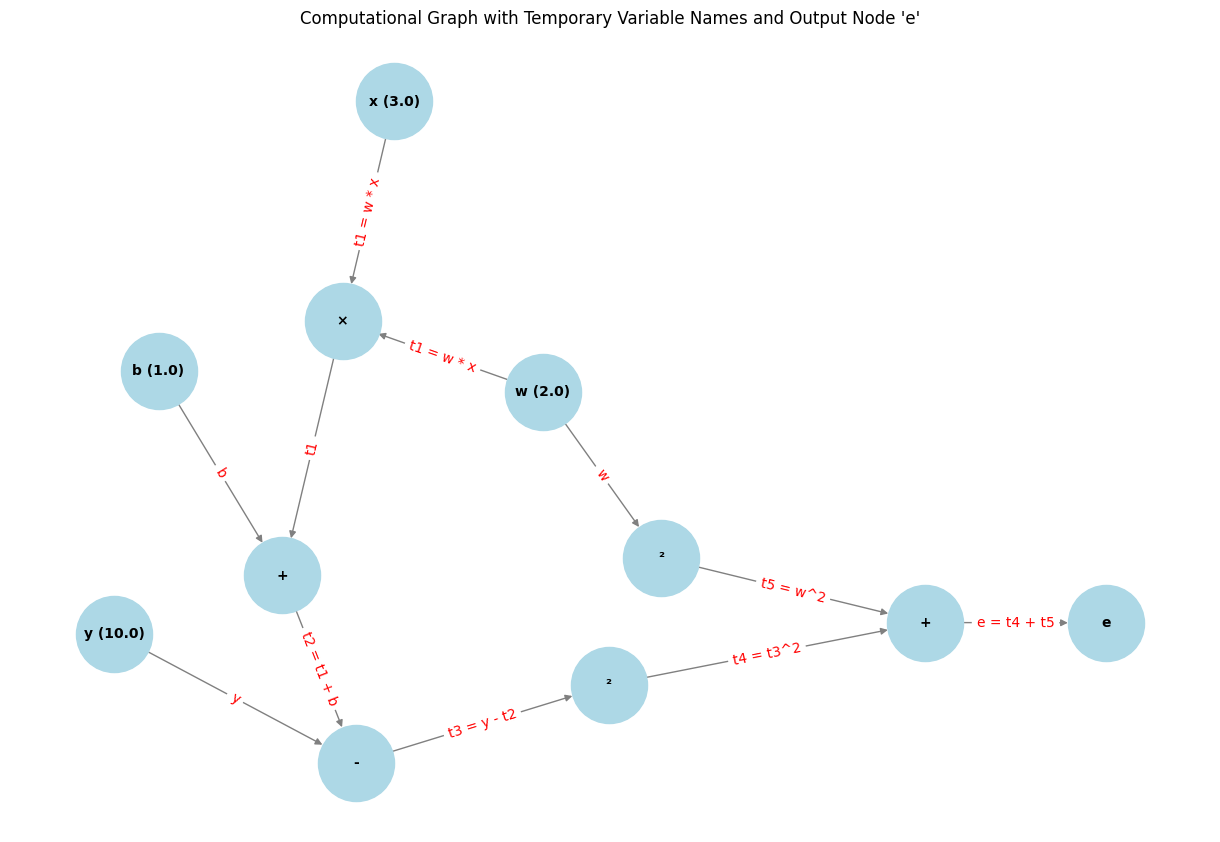

In [1]:
# No need to edit the code.

import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define nodes with operators forming nodes instead of variables
nodes = {
    "w": "w (2.0)",
    "x": "x (3.0)",
    "b": "b (1.0)",
    "y": "y (10.0)",
    "mul1": "×",  # Multiplication node for w * x (t1)
    "add1": "+",  # Addition node for (w * x) + b (t2)
    "sub1": "-",  # Subtraction node for y - ŷ (t3)
    "pow1": "²",  # Squaring node for (y - ŷ)² (t4)
    "pow2": "²",  # Squaring node for w^2 (t5)
    "add2": "+",  # Addition node for t4 + t5 (e)
    "e": "e"      # Output node for the final result
}

# Add nodes to the graph
for key, label in nodes.items():
    G.add_node(key, label=label)

# Define edges with labels for temporary variables (t1, t2, t3, t4, t5, e)
edges_with_labels = {
    ("w", "mul1"): "t1 = w * x",
    ("x", "mul1"): "t1 = w * x",
    ("mul1", "add1"): "t1",
    ("b", "add1"): "b",
    ("add1", "sub1"): "t2 = t1 + b",
    ("y", "sub1"): "y",
    ("sub1", "pow1"): "t3 = y - t2",
    ("pow1", "add2"): "t4 = t3^2",
    ("w", "pow2"): "w",
    ("pow2", "add2"): "t5 = w^2",
    ("add2", "e"): "e = t4 + t5"
}

# Add edges to the graph
G.add_edges_from(edges_with_labels.keys())

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Positioning for aesthetics
labels = nx.get_node_attributes(G, 'label')

# Draw the nodes and edges with labels
nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color="lightblue",
        font_size=10, edge_color="gray", font_weight="bold", arrows=True)

# Draw edge labels (temporary variable names)
edge_labels = {k: v for k, v in edges_with_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="red")

plt.title("Computational Graph with Temporary Variable Names and Output Node 'e'")
plt.show()


# **2️⃣ Backward Pass (Applying Generalized Chain Rule)**

## **Generalized Chain Rule Formula**

For any intermediate variable $t_i$, the gradient with respect to the input $w$ can be computed using the generalized chain rule:

$$
\frac{\partial e}{\partial w} = \sum_{i} \frac{\partial e}{\partial t_i} \cdot \frac{\partial t_i}{\partial w}
$$

where $t_i$ represents the **immediate parents** of $w$ in the computational graph.

---

## **Step-by-Step Gradient Computation**

This autodiff approach consists of two steps. In the first step we compute the values of all intermediate variables and in the second step we apply the chain rule starting at the end.

### **Step 1: Define Intermediate Variables**

1. Compute $t_1$:
$$
t_1 = w \cdot x
$$
Substituting $w = 2$, $x = 3$:
$$
t_1 = 2 \cdot 3 = 6
$$

2. Compute $t_2$:
$$
t_2 = t_1 + b
$$
Substituting $t_1 = 6$, $b = 1$:
$$
t_2 = 6 + 1 = 7
$$

3. Compute $t_3$:
$$
t_3 = y - t_2
$$
Substituting $y = 10$, $t_2 = 7$:
$$
t_3 = 10 - 7 = 3
$$

4. Compute $t_4$:
$$
t_4 = t_3^2
$$
Substituting $t_3 = 3$:
$$
t_4 = 3^2 = 9
$$

5. Compute $t_5$:
$$
t_5 = w^2
$$
Substituting $w = 2$:
$$
t_5 = 2^2 = 4
$$

6. Compute $e$:
$$
e = t_4 + t_5
$$
Substituting $t_4 = 9$, $t_5 = 4$:
$$
e = 9 + 4 = 13
$$

---

## **Step 2: Computing Gradients Using the Generalized Chain Rule**

In order to apply the chain rule, we need to ensure that we have computed the derivative of the output $e$ with respect to every variable but in order to compute the derivative of $e$ with respect to a parent variable using the chain rule, we need to have the derivatives of $e$ with respect to all its children.

Therefore, We start with:
$$
\frac{\partial e}{\partial e} = 1
$$

And then apply the following steps to compute derivatives in reverse topological order.

### **Step 2i: Compute $\frac{\partial e}{\partial t_4}$ and $\frac{\partial e}{\partial t_5}$**

Since:
$$
e = t_4 + t_5
$$

Differentiating:
$$
\frac{\partial e}{\partial t_4} = 1, \quad \frac{\partial e}{\partial t_5} = 1
$$

---

### **Step 2ii: Compute $\frac{\partial t_4}{\partial t_3}$**

Since:
$$
t_4 = t_3^2
$$

Differentiating:
$$
\frac{\partial t_4}{\partial t_3} = 2 t_3
$$

Substituting $t_3 = 3$:
$$
\frac{\partial t_4}{\partial t_3} = 2 \cdot 3 = 6
$$

Applying the generalized chain rule:
$$
\frac{\partial e}{\partial t_3} = \frac{\partial e}{\partial t_4} \cdot \frac{\partial t_4}{\partial t_3}
$$

Substituting:
$$
\frac{\partial e}{\partial t_3} = 1 \cdot 6 = 6
$$

---

### **Step 2iii: Compute $\frac{\partial t_3}{\partial t_2}$**

Since:
$$
t_3 = y - t_2
$$

Differentiating:
$$
\frac{\partial t_3}{\partial t_2} = -1
$$

Applying the generalized chain rule:
$$
\frac{\partial e}{\partial t_2} = \frac{\partial e}{\partial t_3} \cdot \frac{\partial t_3}{\partial t_2}
$$

Substituting values:
$$
\frac{\partial e}{\partial t_2} = 6 \cdot (-1) = -6
$$

---

### **Step 2iv: Compute $\frac{\partial t_2}{\partial t_1}$ and $\frac{\partial t_2}{\partial b}$**

Since:
$$
t_2 = t_1 + b
$$

Differentiating:
$$
\frac{\partial t_2}{\partial t_1} = 1, \quad \frac{\partial t_2}{\partial b} = 1
$$

Applying the generalized chain rule:

For $t_1$:
$$
\frac{\partial e}{\partial t_1} = \frac{\partial e}{\partial t_2} \cdot \frac{\partial t_2}{\partial t_1}
$$

For $b$:
$$
\frac{\partial e}{\partial b} = \frac{\partial e}{\partial t_2} \cdot \frac{\partial t_2}{\partial b}
$$

Substituting values:
$$
\frac{\partial e}{\partial t_1} = (-6) \cdot 1 = -6
$$
$$
\frac{\partial e}{\partial b} = (-6) \cdot 1 = -6
$$

---

### **Step 2v: Compute $\frac{\partial t_1}{\partial w}$ and $\frac{\partial t_5}{\partial w}$**

Since:
$$
t_1 = w \cdot x, \quad t_5 = w^2
$$

Differentiating:
$$
\frac{\partial t_1}{\partial w} = x, \quad \frac{\partial t_5}{\partial w} = 2w
$$

Substituting $w = 2$, $x = 3$:
$$
\frac{\partial t_1}{\partial w} = 3, \quad \frac{\partial t_5}{\partial w} = 4
$$

Applying the generalized chain rule:

For $w$:
$$
\frac{\partial e}{\partial w} = \frac{\partial e}{\partial t_1} \cdot \frac{\partial t_1}{\partial w} + \frac{\partial e}{\partial t_5} \cdot \frac{\partial t_5}{\partial w}
$$

Substituting values:
$$
\frac{\partial e}{\partial w} = (-6) \cdot 3 + 1 \cdot 4 = -18 + 4 = -14
$$

---

## **3️⃣ Final Computed Gradients**

Thus, the computed gradients using the **generalized chain rule** are:

$$
\frac{\partial e}{\partial w} = -14, \quad \frac{\partial e}{\partial x} = -12, \quad \frac{\partial e}{\partial b} = -6
$$

✅ **The generalized chain rule provides a systematic approach to compute all gradients efficiently!** 🚀


# **📌 Towards General Rules for Applying the Chain Rule in a Computation Graph**

Below, we discuss the general steps we need to use to apply the chain rule to any computation graph:
---

## **1. Initialize the Output Gradient**

- Start at the **final output node** (e.g., the objective function).
- Set the **seed gradient** for the **output variable** to **1**, because:

$$
\frac{\partial e}{\partial e} = 1
$$

This initialization acts as the **starting point** for backpropagation.

---

## **2. Traverse the Computation Graph in Reverse Topological Order**

- Perform a **depth-first traversal** of the **computation graph**.
- Ensure that **all child nodes** are processed **before their parent nodes**.
- The **reverse topological order** is crucial because it guarantees that **when processing a node**, the **gradients of its children** are **already computed**.

---

## **3. Apply the Generalized Chain Rule to Each Operation**

For each **operation node** in the **computation graph**, apply the **generalized chain rule**:

$$
\frac{\partial e}{\partial w} = \sum_{i} \frac{\partial e}{\partial t_i} \cdot \frac{\partial t_i}{\partial w}
$$

where $t_i$ are the **immediate parents** of $w$.

---

## **4. Use General Differentiation Rules for Common Operations**

Below we write the general rules (based on the chain rule) for different possible nodes in a computation graph and how the gradients are handled through them in the backward pass. Here, we have a temporaty variable $t$ that is involved in the calculation of the final variable $e$ but $t$ itself is based on specific variables $a$ or $b$ or both. **As long as we can write a gradient rule for the backward pass through an operation, we can use it in our automatic differentiation library!!**

| **Operation** | **Forward Pass** | **Gradient Rule (Backward Pass)** | **Why This Rule Exists** |
|---------------|------------------|---------------------------------|--------------------------|
| **Addition** | $t = a + b$ | $\frac{\partial e}{\partial a} = \frac{\partial e}{\partial t} \cdot 1$ | When $t = a + b$, $\frac{\partial t}{\partial a} = 1$ because **increasing $a$ by 1** increases **$t$ by 1**. |
| | | $\frac{\partial e}{\partial b} = \frac{\partial e}{\partial t} \cdot 1$ | **Same logic applies** to $b$ as for $a$. |
| **Subtraction** | $t = a - b$ | $\frac{\partial e}{\partial a} = \frac{\partial e}{\partial t} \cdot 1$ | For $t = a - b$, **$t$ changes directly with $a$**, hence $\frac{\partial t}{\partial a} = 1$. |
| | | $\frac{\partial e}{\partial b} = \frac{\partial e}{\partial t} \cdot -1$ | For $b$, **increasing $b$ by 1** **decreases $t$ by 1**, giving $\frac{\partial t}{\partial b} = -1$. |
| **Multiplication** | $t = a \cdot b$ | $\frac{\partial e}{\partial a} = \frac{\partial e}{\partial t} \cdot b$ | The **product rule** states that $\frac{\partial t}{\partial a} = b$, as **$t$ scales with $b$** when **$a$ changes**. |
| | | $\frac{\partial e}{\partial b} = \frac{\partial e}{\partial t} \cdot a$ | **Symmetric to $a$**, where **$t$ scales with $a$** when **$b$ changes**. |
| **Division** | $t = \frac{a}{b}$ | $\frac{\partial e}{\partial a} = \frac{\partial e}{\partial t} \cdot \frac{1}{b}$ | Since $t = a \cdot b^{-1}$, apply **product and power rules**. |
| | | $\frac{\partial e}{\partial b} = \frac{\partial e}{\partial t} \cdot \left(-\frac{a}{b^2}\right)$ | The **negative sign** reflects how **increasing $b$** **decreases $t$**. |
| **Power** | $t = a^n$ | $\frac{\partial e}{\partial a} = \frac{\partial e}{\partial t} \cdot n \cdot a^{n-1}$ | From the **power rule**, if $t = a^n$, then $\frac{\partial t}{\partial a} = n a^{n-1}$. |


---

## **5. Accumulate Gradients When Variables are Reused**

If a **variable** is involved in **multiple operations**, **accumulate** the **gradients** using **addition**. This ensures that the **total influence** of the **variable** on the **output** is **correctly accumulated**. This follows from the general form of the chain rule.

If $w$ influences $e$ through **multiple intermediate variables** $t_1, t_2, \ldots, t_n$, then:

$$
\frac{\partial e}{\partial w} = \sum_{i=1}^n \frac{\partial e}{\partial t_i} \cdot \frac{\partial t_i}{\partial w}
$$

Where:

- $t_i$ are the **immediate children** of $w$ in the **computation graph**.
- Each term $\frac{\partial e}{\partial t_i} \cdot \frac{\partial t_i}{\partial w}$ represents the **gradient contribution** from a **specific path** through **intermediate variable** $t_i$.



---

## **6. Reset Gradients Before a New Backward Pass**

- Before starting a **new backward pass**, **reset all gradients to zero** to avoid **accidental accumulation** from **previous passes**.

---

## **7. Stop Gradient Propagation for Non-Differentiable Operations**

- If a **node** in the graph **does not require gradients**, **skip gradient propagation** through this node.
---

## **📝 Summary**

Thus, the application of the general rules for backpropagation can be summarised as:

1. **Initialize** the **seed gradient** at the **output node**.
2. **Traverse the computation graph** in **reverse topological order**.
3. Apply the **generalized chain rule** to **each operation** using **standard differentiation rules**.
4. **Accumulate gradients** when a **variable is reused**.
5. **Reset gradients** before a **new backward pass**.
6. **Skip propagation** for **non-differentiable nodes**.

These **general rules** ensure a **systematic and efficient approach** to **automatic differentiation** in **computation graphs** which we will implement in the next section!


## **Implementing Reverse-Mode Autodiff in Python**
We will now implement reverse-mode autodiff step by step using the general steps derived above.
The `Tensor` class provides the foundation for reverse-mode automatic differentiation by **managing both values and their gradients** while dynamically building a computation graph. Instead of computing derivatives manually, this implementation **attaches a small function to each operation** that describes how its result depends on its inputs and how the gradients should propagate when differentiation is performed. Each operation, like addition or multiplication, registers **how it should compute its own derivative**, ensuring that when `.backward()` is called, the system can **traverse the computation graph in reverse**, applying the **chain rule** recursively. This allows complex functions to be differentiated automatically by **tracking dependencies** rather than symbolically solving for derivatives.

Note that in this code: `t.grad`$ = \frac{\partial e}{\partial t}$ is the derivative of the output $e$ with respect to the variable $t$.


You are welcome to try and add other operators to it.



In [2]:
class DiffScalar:
    def __init__(self, value, requires_grad=False):
        """
        Initialize a scalar value that supports automatic differentiation.

        Arguments:
        - value: The numerical value of the scalar.
        - requires_grad: Whether this scalar requires gradient computation.

        Attributes:
        - grad: Stores the gradient of L (final output) wrt to this variable (set to 0 if differentiation is needed).
        - _backward: A function that defines how gradients should be propagated.
        - _prev: Tracks the dependent variables (parents in computation graph).
        """
        self.value = value
        self.requires_grad = requires_grad
        self.grad = 0 if requires_grad else None  # Initialize gradient
        self._backward = lambda: None  # Placeholder for gradient propagation
        self._prev = set()  # Store references to parent nodes in computation graph

    def __add__(self, other):
        """Define addition operation while maintaining the computation graph."""
        other = other if isinstance(other, DiffScalar) else DiffScalar(other)
        out = DiffScalar(self.value + other.value, requires_grad=self.requires_grad or other.requires_grad)

        def _backward():
            """Compute the gradient using the chain rule."""
            if self.requires_grad:
                self.grad += out.grad  # ∂L/∂self = 1
            if other.requires_grad:
                other.grad += out.grad  # ∂L/∂other = 1

        out._backward = _backward
        out._prev = {self, other}
        return out

    def __sub__(self, other):
        """Define subtraction operation while maintaining the computation graph."""
        other = other if isinstance(other, DiffScalar) else DiffScalar(other)
        out = DiffScalar(self.value - other.value, requires_grad=self.requires_grad or other.requires_grad)

        def _backward():
            """Compute the gradient using the chain rule."""
            if self.requires_grad:
                self.grad += out.grad  # ∂L/∂self = 1
            if other.requires_grad:
                other.grad -= out.grad  # ∂L/∂other = -1

        out._backward = _backward
        out._prev = {self, other}
        return out

    def __mul__(self, other):
        """Define multiplication operation while maintaining the computation graph."""
        other = other if isinstance(other, DiffScalar) else DiffScalar(other)
        out = DiffScalar(self.value * other.value, requires_grad=self.requires_grad or other.requires_grad)

        def _backward():
            """Compute the gradient using the chain rule."""
            if self.requires_grad:
                self.grad += other.value * out.grad  # ∂L/∂self = other.value
            if other.requires_grad:
                other.grad += self.value * out.grad  # ∂L/∂other = self.value

        out._backward = _backward
        out._prev = {self, other}
        return out

    def __pow__(self, exponent):
        """Define power operation while maintaining the computation graph."""
        out = DiffScalar(self.value ** exponent, requires_grad=self.requires_grad)

        def _backward():
            """Compute the gradient using the chain rule."""
            if self.requires_grad:
                self.grad += exponent * (self.value ** (exponent - 1)) * out.grad  # ∂L/∂self = exponent * self^(exponent-1)

        out._backward = _backward
        out._prev = {self}
        return out

    def backward(self):
        """Perform backpropagation to compute gradients of all dependent variables."""
        self.zero_grad()
        self.grad = 1  # Seed gradient for the output (∂L/∂self = 1)

        topo = []  # Store nodes in topological order
        visited = set()

        def build_topo(node):
            """Perform a depth-first traversal to build a valid topological order."""
            if node not in visited:
                visited.add(node)
                for parent in node._prev:
                    build_topo(parent)
                topo.append(node)

        build_topo(self)

        for node in reversed(topo):
            node._backward()

    def zero_grad(self):
        """Reset gradients to zero for this node and all its dependencies."""
        visited = set()

        def reset_grads(node):
            if node not in visited:
                visited.add(node)
                if node.requires_grad:
                    node.grad = 0  # Reset gradient
                for parent in node._prev:
                    reset_grads(parent)

        reset_grads(self)


# **TEST CASE: Compute e = (y - (w*x + b))^2**
w = DiffScalar(2.0, requires_grad=True)  # Weight
x = DiffScalar(3.0, requires_grad=True)  # Input
b = DiffScalar(1.0, requires_grad=True)  # Bias
y = DiffScalar(10.0, requires_grad=False)  # Ground truth

e = (y - (w * x + b)) ** 2 + w ** 2

# Perform backward pass
e.backward()

# Print gradients
print(f"w.grad = {w.grad}")  # Expected: -2 * (y - y_hat) * x
print(f"x.grad = {x.grad}")  # Expected: -2 * (y - y_hat) * w
print(f"b.grad = {b.grad}")  # Expected: -2 * (y - y_hat)


w.grad = -14.0
x.grad = -12.0
b.grad = -6.0


Which is exactly equal to what we calculated outselves!!

All major automatic differentiation (autodiff) libraries, including PyTorch, TensorFlow, JAX, and Autograd, implement similar algorithms for computing gradients efficiently. These libraries use reverse-mode automatic differentiation (also known as backpropagation) to automatically compute derivatives of complex functions with respect to their inputs. This capability is crucial for training machine learning models, especially deep neural networks, where gradient-based optimization techniques such as stochastic gradient descent (SGD) are widely used. These libraries also allow more efficient computation through the use of Graphical Processing Units (GPUs) or Tensor Processing Units (TPUs) for vectorized operations. While these libraries provide powerful autodiff tools, some programming languages—like Julia—are taking this a step further by offering native support for automatic differentiation. This means that differentiation is not just an added feature through external libraries, but rather, it is deeply integrated into the language itself. Such native support enables what is known as Differentiable Programming, where differentiation can be applied to any code, not just predefined computational graphs.


## PyTorch Comparison

Let's compare to pyTorch using the same example:

In [3]:
import torch

# Define variables in PyTorch with requires_grad=True
w = torch.tensor(2.0, requires_grad=True)  # Weight
x = torch.tensor(3.0, requires_grad=True)  # Input
b = torch.tensor(1.0, requires_grad=True)  # Bias
y = torch.tensor(10.0, requires_grad=False)  # Ground truth

e = (y - (w * x + b)) ** 2 + w ** 2


# Perform backward pass
e.backward()

# Extract gradients
print(f"w.grad = {w.grad.item()}")  # Expected: -2 * (y - y_hat) * x
print(f"x.grad = {x.grad.item()}")  # Expected: -2 * (y - y_hat) * w
print(f"b.grad = {b.grad.item()}")  # Expected: -2 * (y - y_hat))


w.grad = -14.0
x.grad = -12.0
b.grad = -6.0


Let's visualist the pytorch computation graph.

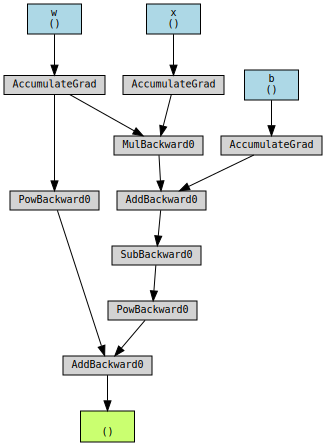

In [4]:
!pip install torchviz
import torch
from torchviz import make_dot

# Define variables
w = torch.tensor(2.0, requires_grad=True)
x = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(10.0)

# Compute function
e = (y - (w * x + b)) ** 2 + w ** 2


# Perform backpropagation
e.backward()

# Generate and render computational graph
make_dot(e, params={"w": w, "x": x, "b": b})




# **⏱️ Computational Complexity of Reverse-Mode Automatic Differentiation**

---

## **1. Time Complexity**

### **Key Points:**
- **Reverse-mode autodiff** computes **gradients of a scalar output** (e.g., a **loss function**) with respect to **all input variables** in a **single backward pass**.
- This is **highly efficient** when the **number of inputs** ($n$) is **large**, and the **number of outputs** ($m$) is **small** (typically **$m = 1$** for **scalar loss functions**).

### **Time Complexity Analysis:**

If there are:

- **$n$ input variables** ($w_1, w_2, \ldots, w_n$)
- **$L$ operations** in the **computation graph**

Then the **time complexity** of:

1. **Forward Pass:** $O(L)$
   - The **forward pass** **evaluates the function** and **stores intermediate values**.
   - Each **operation** in the **computation graph** is **evaluated once**.

2. **Backward Pass:** $O(L)$
   - The **backward pass** **propagates gradients** by **applying the chain rule**.
   - Each **operation** is **differentiated once**, and **gradients** are **accumulated**.

### **Overall Time Complexity:**

$$
O(L) + O(L) = O(L)
$$

This means that **reverse-mode autodiff** can compute **gradients with respect to all inputs** in **constant time** relative to the **number of inputs**, but **linear time** relative to the **number of operations**.

---

## **2. Memory Complexity**

### **Key Points:**
- **Memory complexity** is driven by the **need to store intermediate values** during the **forward pass**, which are **required during backpropagation**.
- The **memory footprint** includes:
  - **Intermediate variable values** for **computing gradients**.
  - **Gradient values** for **each node** in the **computation graph**.

### **Memory Complexity:**

If there are:

- **$L$ intermediate variables** (**equal to the number of operations**) in the **computation graph**

Then the **memory complexity** is:

$$
O(L)
$$

This complexity arises because **reverse-mode autodiff** needs to **store all intermediate values** in order to **apply the chain rule** in the **backward pass**.

---

## **3. Combined Complexity**

| **Metric**          | **Complexity** | **Explanation**                                                                 |
|---------------------|----------------|---------------------------------------------------------------------------------|
| **Time Complexity** | $O(L)$         | **Linear** with respect to the **number of operations** ($L$) in the **computation graph**. |
| **Memory Complexity** | $O(L)$         | **Linear** with respect to the **number of intermediate variables** ($L$) needed for **backpropagation**. |

---

## **4. Trade-Offs and Considerations**

### **1. Memory Bottleneck:**
- **Memory usage** can become a **bottleneck** for **deep neural networks** with **many layers** or computing the gradients over **large numbber of input examples at once (batch size)**.
- **Techniques like checkpointing** can help by **trading off computation for memory**, **recomputing intermediate values** during the **backward pass** instead of **storing them all**. Using lower-precision numbers can help further. Another approach is to use reversible layers which have O(1) memory complexity (at increased computational cost though).

### **2. Ideal Use Case for Reverse-Mode Autodiff:**
- **Reverse-mode autodiff** is **most efficient** when the **number of inputs** ($n$) is **large**, and the **number of outputs** ($m$) is **small**.
- This makes it **ideal for machine learning**, where **models** often have **millions of parameters**, but the **loss function** is a **single scalar**.

### **3. Comparison with Forward-Mode Autodiff:**
- **Forward-mode autodiff** has **time complexity** of $O(L \cdot n)$ for **n outputs**, making it **preferable** when **$m > n$**, such as in **Jacobian matrix computation** for **vector-valued functions**.

---

## **5. Conclusion:**

- **Reverse-mode autodiff** achieves **efficient gradient computation** with **linear time complexity** relative to the **number of operations**.
- However, its **linear memory complexity** can be **challenging** for **very deep or complex computation graphs**.
- By **understanding these complexities**, developers can **optimize memory usage** and **choose the appropriate autodiff technique** for their **specific problem domain**.
